# Off-by-one error

This notebook is a quick analysis of deep learnings ability to find off-by-one decimal errors in an income distribution. The income distribution will be simulated with a log-normal distribution.

## Libraries

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
from tensorflow import keras

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

The following command checks which devices TensorFlow has access to. It's a great way to check if TensorFlow is reading a GPU correctly.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11084783413010809993
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5190320128
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10033567365510194153
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Boilerplate (Fake Data Creation)

TODO move to separate file

In [4]:
def off_by_one(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=0.1, data=None, ordinal_error=True):
    """Create log-normal data set with off-by-one decimal error."""

    if data is None:
        true_value = np.random.lognormal(mu, sigma, n)
    else:
        true_value = data
        n = len(true_value)
    true_value = [round(i, 5) for i in true_value]
    if ordinal_error:
        error_types = [1,2,3] #-1 for left error, 1 for right error, 0 for no error.
        # tensorflow is doing a one-hot encoding, although on future iterations we would like to keep the
        # ordinal (not cardinal) nature of the error.
        error = np.random.choice(error_types, n, p=[error_rate/2, error_rate/2, 1-error_rate])
    else:
        error = np.random.binomial(1, error_rate, n)
    
    observed = np.zeros(n)
    for i in range(n):
        if error[i] == 1:
            observed[i] = true_value[i]/10
        elif error[i] == 2:
            observed[i] = true_value[i]*10
        else:
            observed[i] = true_value[i]
    data = {"error" : error, "observed" : observed, "true_value" : true_value}
    return pd.DataFrame(data=data)

In [5]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Introduction

As the amount of error increases, the observed and true value distributions become more separable. Note that with this log-normal distribution, the observed distribution becomes bimodal. However, we would expect 

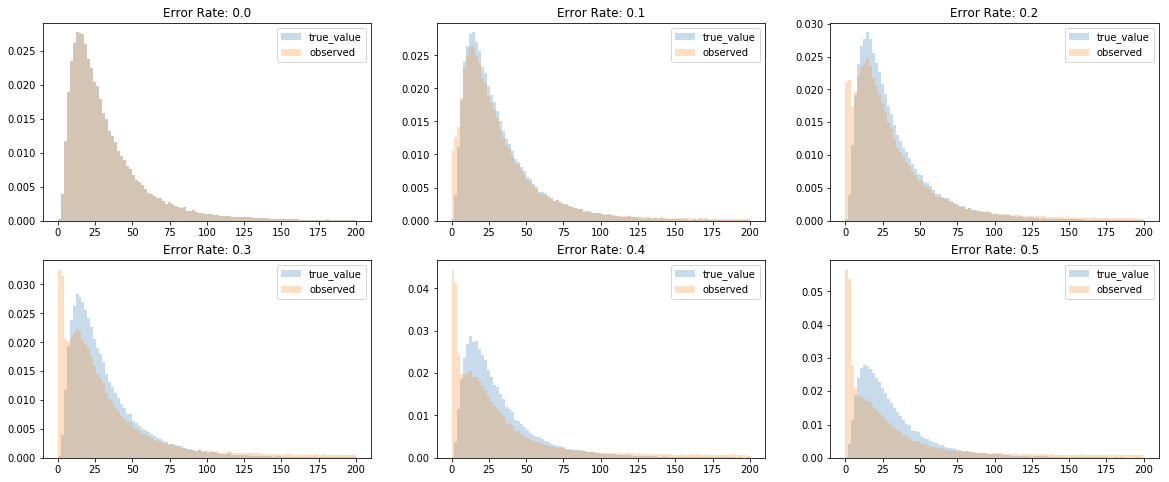

In [6]:
df = [off_by_one(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=i) for i in np.arange(0, .6, 0.1)]

fig, axs = plt.subplots(2,3, figsize=(20,8), facecolor='w', edgecolor='k')

for ax, i in zip(axs.ravel(), range(0,6)):
        ax.hist(df[i]["true_value"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.hist(df[i]["observed"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.legend()
        ax.set_title("Error Rate: " + str(round(i*0.1, 2)))
plt.show()

## Modeling

The standard pipeline for ML is to first do an initial train/test split. This test set is also known as the holdout set as we will also split the training data set again for Cross Validation when tuning the neural net. 

In [7]:
train, test = train_test_split(df[3], test_size=0.25)
test_len = len(test)
X_train = np.array(train["observed"]).reshape(-1, 1)
y_train = np.array(train["error"])
X_test = np.array(test["observed"]).reshape(-1, 1)
y_test = np.array(test["error"])

### Deep Learning (Neural net)

Building neural nets in Tensorflow is straightforward esp. using the Keras API. The Keras API has three parts to it: building the underlying model, compiling the model, and fitting the model. In the first step, one defines the  structure of the neural net. 'model.compile' defines the optimizer to solve the neural net, loss function (or objective function), and metrics. Lastly, 'model.fit' runs the process to fit the neural net and returns the previous metrics defined in the process. Currently, neural nets have a difficult time fitting this data. I need to research more on this topic.

In [22]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.softmax)
  ])
    model.compile(optimizer=tf.train.AdamOptimizer(),
                  loss=tf.keras.losses.categorical_hinge,
                  metrics=['accuracy'])
    return model

model = build_model()

In [23]:
# Print evidence of each epoch ending in readable format
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.25, verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[PrintDot()])


..........
..........
..........
..........
..........
..........
..........
..........
..........
..........

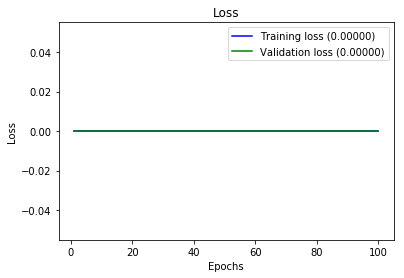

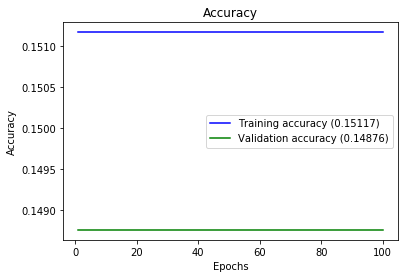

In [24]:
plot_historyory(history)

### Random Forest

sklearn framework is based on a single objection (the estimator) and two commands (fit and predict). This convention is followed in all sklearn methods whether it is a linear regression or a random forest.

In [11]:
rfc = RFC()
rfc.fit(X_train, y_train)
y_test_hat = rfc.predict(X_test)

In [12]:
accuracy_score(y_test_hat, y_test)

0.88484

### Gradient Boosting

In [13]:
gbc = GBC()
gbc.fit(X_train, y_train)
y_test_hat = gbc.predict(X_test)

In [14]:
accuracy_score(y_test_hat, y_test)

0.92036

### Bayesian Hierarchical modeling (TODO)

pyStan 

In [15]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
}
parameter {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=0> error_rate;
}
transformed parameters {
    real observed[N];
    for (n in 1:N){
      observed[N] = true_value*error_rate
    }
}
model {
    error ~ bernoulli(error_rate)
}
"""

data = {'n': np.shape(X_train)[0],
        'x': X_train.reshape(np.shape(X_train)[0])}

sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)

ValueError: Failed to parse Stan model 'anon_model_10e3bdcfd77244e44ecd083edad01dc7'. Error message:
PARSER EXPECTED: whitespace to end of file.
FOUND AT line 6: 
parameter {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=0> error_rate;
}
transformed parameters {
    real observed[N];
    for (n in 1:N){
      observed[N] = true_value*error_rate
    }
}
model {
    error ~ bernoulli(error_rate)
}




